Adapted from https://www.kaggle.com/code/taylorsamarel/change-python-version-on-kaggle-taylor-amarel

In [1]:
!python --version

Python 3.7.12


In [2]:
# Create New Conda Environment and Use Conda Channel 
!conda create -n newCondaEnvironment -c cctbx202208 python=3.8.5 -y
!source /opt/conda/bin/activate newCondaEnvironment && conda install -c cctbx202208 python -y

Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/newCondaEnvironment

  added / updated specs:
    - python=3.8.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  cctbx202208
    _openmp_mutex-4.5          |            2_gnu          23 KB  cctbx202208
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  cctbx202208
    ld_impl_linux-64-2.36.1    |       hea4e1c9_2         667 KB  cctbx202208
    libffi-3.2.1               |    he1b5a44_1007          47 KB  conda-forge
    libgcc-ng-12.1

In [3]:
!/opt/conda/envs/newCondaEnvironment/bin/python3 --version
!echo 'print("Hello, World!")' > test.py
!/opt/conda/envs/newCondaEnvironment/bin/python3 test.py

Python 3.8.5
Hello, World!


In [4]:
!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python3

In [5]:
!sudo rm /opt/conda/bin/python3.7
!sudo ln -sf /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python3.7

In [6]:
!sudo rm /opt/conda/bin/python
!sudo ln -s /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python

In [7]:
!python --version

Python 3.8.5


In [8]:
!python --version

Python 3.8.5


In [9]:
!pip install numpy==1.20.1 torch==1.7.1 tqdm==4.56.1 transformers==4.5.1 tensorboard==2.4.1 scikit-learn==0.24.1 PyYAML==5.4.1 click==7.1.2 sentencepiece==0.1.95

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 24.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 18.3 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 39.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.1/785.1 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 66.4 MB/s e

In [38]:
import json
import logging
import os

import click
import torch
import transformers
from transformers import AutoConfig, AutoTokenizer
from transformers.trainer_utils import is_main_process

In [39]:
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader


In [40]:
def load_conf(path):
    with open(path) as fin:
        conf_txt = fin.read()
    conf = yaml.load(conf_txt, Loader=Loader)
    assert 'raw_yaml' not in conf
    conf['raw_yaml'] = conf_txt

    if conf['task'] not in ['identification_classification', 'classification']:
        raise ValueError(
            "task must be either 'classification' or 'identification_classification'")

    if conf['task'] == 'identification_classification' and conf['doc_stride'] >= conf['max_seq_length'] - conf['max_query_length']:
        raise RuntimeError(
            "WARNING - You've set a doc stride which may be superior to the document length in some "
            "examples. This could result in errors when building features from the examples. Please reduce the doc "
            "stride or increase the maximum length to ensure the features are correctly built."
        )
    return conf


In [41]:
from typing import Tuple, List, Optional, Union
import torch
from torch.utils.data import TensorDataset


In [42]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import List, Tuple
import enum

# import tqdm


class NLILabel(enum.Enum):
    NOT_MENTIONED = 0
    ENTAILMENT = 1
    CONTRADICTION = 2

    @classmethod
    def from_str(cls, s: str):
        if s == 'NotMentioned':
            return cls.NOT_MENTIONED
        elif s == 'Entailment':
            return cls.ENTAILMENT
        elif s == 'Contradiction':
            return cls.CONTRADICTION
        else:
            raise ValueError(f'Invalid input "{"s"}" to NLILabel.from_str.')

    def to_anno_name(self):
        if self == NLILabel.NOT_MENTIONED:
            return 'NotMentioned'
        elif self == NLILabel.ENTAILMENT:
            return 'Entailment'
        elif self == NLILabel.CONTRADICTION:
            return 'Contradiction'
        else:
            assert not 'Should not get here'


class ContractNLIExample:
    """
    A single training/test example for the contract NLI.

    Args:
        data_id: The example's unique identifier
        hypothesis_text: The hypothesis string
        context_text: The context string
        answer_text: The answer string
        start_position_character: The character position of the start of the answer
    """

    def __init__(
        self,
        *,
        data_id,
        document_id,
        hypothesis_id,
        file_name,
        hypothesis_text,
        hypothesis_tokens,
        context_text,
        tokens,
        splits,
        spans,
        char_to_word_offset,
        label,
        annotated_spans
    ):
        self.data_id: str = data_id
        self.document_id: str = document_id
        self.hypothesis_id: str = hypothesis_id
        self.hypothesis_symbol: str = f'[{hypothesis_id}]'
        self.file_name: str = file_name
        self.hypothesis_text: str = hypothesis_text
        self.hypothesis_tokens: List[str] = hypothesis_tokens
        self.context_text: str = context_text
        self.tokens: List[str] = tokens
        # Note that splits are NOT unique
        self.splits: List[int] = splits
        self.spans: List[Tuple[int, int]] = spans
        self.char_to_word_offset: List[int] = char_to_word_offset
        self.label: NLILabel = label
        self.annotated_spans: List[int] = annotated_spans

    @staticmethod
    def tokenize_and_align(text: str, spans: List[Tuple[int, int]]):
        """
        spans: Spans as character offsets. e.g. "world" in "Hello, world" will
            be represented as (7, 12).
        """
        # Split on whitespace so that different tokens may be attributed to their original position.
        tokens = []
        char_to_word_offset = []
        prev_is_whitespace = True
        splits = {si for s in spans for si in s}

        for i, c in enumerate(text):
            if c == ' ':
                # splits will be ignored on space
                prev_is_whitespace = True
            else:
                if prev_is_whitespace or i in splits:
                    tokens.append(c)
                else:
                    tokens[-1] += c
                prev_is_whitespace = False
            # len(tokens) == 0 when first characters are spaces
            char_to_word_offset.append(max(len(tokens) - 1, 0))

        splits = [char_to_word_offset[s[0]] for s in spans]
        return tokens, splits, char_to_word_offset

    @classmethod
    def load(cls, input_data) -> List['ContractNLIExample']:
        examples = []
        label_dict = {
            label_id: label_info['hypothesis']
            for label_id, label_info in input_data['labels'].items()}
        for document in tqdm(input_data['documents']):
            if len(document['annotation_sets']) != 1:
                raise RuntimeError(
                    f'{len(document["annotation_sets"])} annotation sets given but '
                    'we only support single annotation set.')
            for label_id, annotation in document['annotation_sets'][0]['annotations'].items():
                data_id = f'{document["id"]}_{label_id}'
                context_text = document['text']
                hypothesis_text = label_dict[label_id]

                tokens, splits, char_to_word_offset = cls.tokenize_and_align(
                    context_text, document['spans'])
                hypothesis_tokens, _, _ = cls.tokenize_and_align(
                    hypothesis_text, [])
                assert len(splits) == len(document['spans'])
                example = cls(
                    data_id=data_id,
                    document_id=document["id"],
                    hypothesis_id=label_id,
                    file_name=document['file_name'],
                    hypothesis_text=hypothesis_text,
                    hypothesis_tokens=hypothesis_tokens,
                    context_text=context_text,
                    tokens=tokens,
                    splits=splits,
                    spans=document['spans'],
                    char_to_word_offset=char_to_word_offset,
                    label=NLILabel.from_str(annotation['choice']),
                    annotated_spans=annotation['spans']
                )
                examples.append(example)
        return examples


In [43]:
# Copyright 2020 The HuggingFace Team. and Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/495c157d6fcfa29f2d9e1173582d2fb5a393c323/src/transformers/data/processors/squad.py
# and has been modified. See git log for the full details of changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from functools import partial
from multiprocessing import Pool, cpu_count
from typing import List, Dict
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import TensorDataset
from tqdm import tqdm
from transformers.tokenization_utils_base import BatchEncoding, \
    PreTrainedTokenizerBase
from transformers.utils import logging

# from contract_nli.dataset.loader import ContractNLIExample, NLILabel

# Store the tokenizers which insert 2 separators tokens
MULTI_SEP_TOKENS_TOKENIZERS_SET = {"roberta", "camembert", "bart", "mpnet"}
SPAN_TOKEN = '[SPAN]'


logger = logging.get_logger(__name__)


class IdentificationClassificationFeatures:
    """
    Single example features to be fed to a model. Those features are model-specific and can be crafted from
    :class:`~contract_nli.dataset.loader.ContractNLIExample` using the
    :method:`~contract_nli.dataset.encoder.convert_examples_to_features` method.

    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        cls_index: the index of the CLS token.
        p_mask: Mask identifying tokens that can be answers vs. tokens that cannot.
            Mask with 1 for tokens than cannot be in the answer and 0 for token that can be in an answer
        example_index: the index of the example
        unique_id: The unique Feature identifier
        paragraph_len: The length of the context
        token_is_max_context: List of booleans identifying which tokens have their maximum context in this feature object.
            If a token does not have their maximum context in this feature object, it means that another feature object
            has more information related to that token and should be prioritized over this feature for that token.
        tokens: list of tokens corresponding to the input ids
        token_to_orig_map: mapping between the tokens and the original text.
        span_to_orig_map: mapping between the spans and the original spans, needed in order to identify the answer.
        class_label:
        span_labels:
        valid_span_missing_in_context: Class label is NOT "not mentioned" and a valid span is not in the context
        data_id:
        encoding: optionally store the BatchEncoding with the fast-tokenizer alignement methods.
    """

    def __init__(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        cls_index,
        p_mask,
        example_index,
        unique_id,
        paragraph_len,
        token_is_max_context,
        tokens,
        token_to_orig_map,
        span_to_orig_map,
        class_label,
        span_labels,
        valid_span_missing_in_context,
        data_id: str = None,
        encoding: BatchEncoding = None,
    ):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.cls_index = cls_index
        self.p_mask = p_mask

        self.example_index = example_index
        self.unique_id = unique_id
        self.paragraph_len = paragraph_len
        self.token_is_max_context = token_is_max_context
        self.tokens = tokens
        self.token_to_orig_map = token_to_orig_map
        self.span_to_orig_map: Dict[int, List[int]] = span_to_orig_map

        self.class_label = class_label
        self.span_labels = span_labels
        if valid_span_missing_in_context:
            assert class_label in [NLILabel.ENTAILMENT.value, NLILabel.CONTRADICTION.value]
        self.valid_span_missing_in_context = valid_span_missing_in_context
        self.data_id = data_id

        self.encoding = encoding


def _new_check_is_max_context(doc_spans, cur_span_index, position):
    """Check if this is the 'max context' doc span for the token at a position
    `position`.
    """
    # if len(doc_spans) == 1:
    # return True
    best_score = None
    best_span_index = None
    for (span_index, doc_span) in enumerate(doc_spans):
        end = doc_span["start"] + doc_span["paragraph_len"] - 1
        if position < doc_span["start"]:
            continue
        if position > end:
            continue
        num_left_context = position - doc_span["start"]
        num_right_context = end - position
        score = min(num_left_context, num_right_context) + 0.01 * doc_span["paragraph_len"]
        if best_score is None or score > best_score:
            best_score = score
            best_span_index = span_index

    return cur_span_index == best_span_index


def tokenize(tokenizer, tokens: List[str], splits: List[int]):
    tok_to_orig_index = []
    orig_to_tok_index = []
    all_doc_tokens = []
    tok_to_orig_span_index = defaultdict(list)
    for i, s in enumerate(splits):
        tok_to_orig_span_index[s].append(i)
    span_to_orig_index = dict()
    for (i, token) in enumerate(tokens):
        if i in tok_to_orig_span_index:
            span_to_orig_index[len(all_doc_tokens)] = tok_to_orig_span_index[i]
            tok_to_orig_index.append(-1)
            all_doc_tokens.append(SPAN_TOKEN)
        orig_to_tok_index.append(len(all_doc_tokens))
        if tokenizer.__class__.__name__ in [
            "RobertaTokenizer",
            "LongformerTokenizer",
            "BartTokenizer",
            "RobertaTokenizerFast",
            "LongformerTokenizerFast",
            "BartTokenizerFast",
        ]:
            sub_tokens = tokenizer.tokenize(token, add_prefix_space=True)
        else:
            sub_tokens = tokenizer.tokenize(token)
        for sub_token in sub_tokens:
            tok_to_orig_index.append(i)
            all_doc_tokens.append(sub_token)
    return all_doc_tokens, orig_to_tok_index, tok_to_orig_index, span_to_orig_index


def convert_example_to_features(
        example: ContractNLIExample,
        max_seq_length: int,
        doc_stride: int,
        max_query_length: int,
        padding_strategy,
        labels_available: bool,
        symbol_based_hypothesis: bool
        ) -> List[IdentificationClassificationFeatures]:
    features = []

    all_doc_tokens, orig_to_tok_index, tok_to_orig_index, span_to_orig_index = tokenize(
        tokenizer, example.tokens, example.splits)

    if symbol_based_hypothesis:
        truncated_query = [example.hypothesis_symbol]
    else:
        truncated_query = tokenize(tokenizer, example.hypothesis_tokens, [])[0][:max_query_length]

    # Tokenizers who insert 2 SEP tokens in-between <context> & <question> need to have special handling
    # in the way they compute mask of added tokens.
    tokenizer_type = type(tokenizer).__name__.replace("Tokenizer", "").lower()
    sequence_added_tokens = (
        tokenizer.model_max_length - tokenizer.max_len_single_sentence + 1
        if tokenizer_type in MULTI_SEP_TOKENS_TOKENIZERS_SET
        else tokenizer.model_max_length - tokenizer.max_len_single_sentence
    )
    sequence_pair_added_tokens = tokenizer.model_max_length - tokenizer.max_len_sentences_pair
    query_with_special_tokens_length = len(truncated_query) + sequence_added_tokens
    max_context_length = max_seq_length - sequence_pair_added_tokens - len(truncated_query)

    spans = []
    start = 0
    covered_splits = set()
    all_splits = set(span_to_orig_index.keys())
    while len(all_splits - covered_splits) > 0:
        upcoming_splits = [i for i in span_to_orig_index.keys()
                           if i >= start and i not in covered_splits]
        assert len(upcoming_splits) > 0
        second_split = upcoming_splits[1] if len(upcoming_splits) > 1 else len(all_doc_tokens)
        if second_split - upcoming_splits[0] > max_context_length:
            # a single span is larger than maximum allowed tokens ---- there are nothing we can do
            start = upcoming_splits[0]
            last_span_idx = second_split
            covered_splits.add(upcoming_splits[0])
        elif second_split - start > max_context_length:
            # we can fit the first upcoming span if we modify "start"
            start += (second_split - max_context_length)
            last_span_idx = second_split
            covered_splits.add(upcoming_splits[0])
        else:
            # we can fit at least one span
            last_span_idx = None
            for i in range(start, min(start + max_context_length, len(all_doc_tokens)) + 1):
                if i == len(all_doc_tokens) or i in span_to_orig_index:
                    if last_span_idx is not None:
                        covered_splits.add(last_span_idx)
                    last_span_idx = i
            assert last_span_idx is not None

        split_tokens = all_doc_tokens[start:min(start + max_context_length, len(all_doc_tokens))]

        # Define the side we want to truncate / pad and the text/pair sorting
        if tokenizer.padding_side == "right":
            texts = truncated_query
            pairs = split_tokens
        else:
            texts = split_tokens
            pairs = truncated_query

        encoded_dict = tokenizer.encode_plus(
            texts,
            pairs,
            truncation=False,
            padding=padding_strategy,
            max_length=max_seq_length,
            return_overflowing_tokens=False,
            return_token_type_ids=True
        )
        assert len(encoded_dict['input_ids']) <= max_seq_length

        paragraph_len = len(split_tokens)
        if tokenizer.pad_token_id in encoded_dict["input_ids"]:
            if tokenizer.padding_side == "right":
                non_padded_ids = encoded_dict["input_ids"][: encoded_dict["input_ids"].index(tokenizer.pad_token_id)]
            else:
                last_padding_id_position = (
                    len(encoded_dict["input_ids"]) - 1 - encoded_dict["input_ids"][::-1].index(tokenizer.pad_token_id)
                )
                non_padded_ids = encoded_dict["input_ids"][last_padding_id_position + 1 :]
        else:
            non_padded_ids = encoded_dict["input_ids"]

        tokens = tokenizer.convert_ids_to_tokens(non_padded_ids)

        token_to_orig_map = {}
        span_to_orig_map = {}
        for i in range(paragraph_len):
            index = query_with_special_tokens_length + i if tokenizer.padding_side == "right" else i
            if tok_to_orig_index[start + i] != -1:
                token_to_orig_map[index] = tok_to_orig_index[start + i]
                assert (start + i) not in span_to_orig_index
            else:
                assert (start + i) in span_to_orig_index
                span_to_orig_map[index] = span_to_orig_index[start + i]

        encoded_dict["paragraph_len"] = paragraph_len
        encoded_dict["tokens"] = tokens
        encoded_dict["token_to_orig_map"] = token_to_orig_map
        encoded_dict["span_to_orig_map"] = span_to_orig_map
        encoded_dict["truncated_query_with_special_tokens_length"] = query_with_special_tokens_length
        encoded_dict["token_is_max_context"] = {}
        encoded_dict["start"] = start

        spans.append(encoded_dict)

        start = last_span_idx - doc_stride

    # Due to striding splitting, the same token will appear multiple times
    # in different splits. We annotate data with "token_is_max_context"
    # which classifies whether an instance of a token has the longest context
    # amongst different instances of the same token.
    for doc_span_index in range(len(spans)):
        for j in range(spans[doc_span_index]["paragraph_len"]):
            is_max_context = _new_check_is_max_context(
                spans, doc_span_index, spans[doc_span_index]['start'] + j)
            index = (
                j
                if tokenizer.padding_side == "left"
                else query_with_special_tokens_length + j
            )
            spans[doc_span_index]["token_is_max_context"][index] = is_max_context

    span_token_id = tokenizer.additional_special_tokens_ids[tokenizer.additional_special_tokens.index(SPAN_TOKEN)]
    for span in spans:
        # Identify the position of the CLS token
        cls_index = span["input_ids"].index(tokenizer.cls_token_id)

        # p_mask: mask with 1 for token than cannot be in the answer (0 for token which can be in an answer)
        p_mask = np.logical_not(
            np.isin(np.array(span["input_ids"]), [span_token_id, tokenizer.cls_token_id])
        ).astype(np.int32)

        valid_span_missing_in_context = False
        span_labels = np.zeros_like(span["input_ids"])
        if labels_available:
            if example.label != NLILabel.NOT_MENTIONED:
                doc_start = span["start"]
                doc_end = span["start"] + span["paragraph_len"]
                annotated_spans = set(example.annotated_spans)
                _span_labels = np.array([
                    any((s in annotated_spans for s in span_to_orig_index.get(i, [])))
                    for i in range(doc_start, doc_end)
                ]).astype(int)
                if not np.any(_span_labels):
                    valid_span_missing_in_context = True
                tok_start = query_with_special_tokens_length
                tok_end = tok_start + span["paragraph_len"]
                if tokenizer.padding_side == "right":
                    span_labels[tok_start:tok_end] = _span_labels
                else:
                    span_labels[-tok_end:-tok_start] = _span_labels
            class_label = example.label.value
        else:
            class_label = -1

        assert not np.any(np.logical_and(p_mask, span_labels))

        features.append(
            IdentificationClassificationFeatures(
                span["input_ids"],
                span["attention_mask"],
                span["token_type_ids"],
                cls_index,
                p_mask,
                example_index=0,  # Can not set unique_id and example_index here. They will be set after multiple processing.
                unique_id=0,
                paragraph_len=span["paragraph_len"],
                token_is_max_context=span["token_is_max_context"],
                tokens=span["tokens"],
                token_to_orig_map=span["token_to_orig_map"],
                span_to_orig_map=span["span_to_orig_map"],
                class_label=class_label,
                span_labels=span_labels,
                valid_span_missing_in_context=valid_span_missing_in_context,
                data_id=example.data_id,
            )
        )
    return features



def convert_example_to_features_init(tokenizer_for_convert: PreTrainedTokenizerBase):
    global tokenizer
    tokenizer = tokenizer_for_convert


def convert_examples_to_features(
    examples,
    tokenizer,
    max_seq_length,
    doc_stride,
    max_query_length,
    labels_available,
    symbol_based_hypothesis: bool,
    padding_strategy="max_length",
    threads=None,
    tqdm_enabled=True,
):
    """
    Converts a list of examples into a list of features that can be directly
    given as input to a model.

    Args:
        examples: list of :class:`~contract_nli.dataset.loader.ContractNLIExample`
        tokenizer: an instance of a child of :class:`~transformers.PreTrainedTokenizer`
        max_seq_length: The maximum sequence length of the inputs.
        doc_stride: The stride used when the context is too large and is split across several features.
        max_query_length: The maximum length of the query.
        labels_available: whether to create features for model evaluation or model training.
        padding_strategy: Default to "max_length". Which padding strategy to use
        threads: multiple processing threads.
    """
    if threads is None or threads < 0:
        threads = cpu_count()
    else:
        threads = min(threads, cpu_count())
    with Pool(threads, initializer=convert_example_to_features_init, initargs=(tokenizer,)) as p:
        annotate_ = partial(
            convert_example_to_features,
            max_seq_length=max_seq_length,
            doc_stride=doc_stride,
            max_query_length=max_query_length,
            padding_strategy=padding_strategy,
            labels_available=labels_available,
            symbol_based_hypothesis=symbol_based_hypothesis
        )
        features: List[List[IdentificationClassificationFeatures]] = list(
            tqdm(
                p.imap(annotate_, examples, chunksize=32),
                total=len(examples),
                desc="convert examples to features",
                disable=not tqdm_enabled,
            )
        )
    new_features = []
    unique_id = 1000000000
    example_index = 0
    for example_features in tqdm(
        features, total=len(features), desc="add example index and unique id", disable=not tqdm_enabled
    ):
        if not example_features:
            continue
        for example_feature in example_features:
            example_feature.example_index = example_index
            example_feature.unique_id = unique_id
            new_features.append(example_feature)
            unique_id += 1
        example_index += 1
    features: List[IdentificationClassificationFeatures] = new_features
    del new_features

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
    all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)
    all_valid_span_missing_in_context = torch.tensor([f.valid_span_missing_in_context for f in features], dtype=torch.float)

    all_feature_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
    dataset = [
        all_input_ids,
        all_attention_masks,
        all_token_type_ids,
        all_cls_index,
        all_p_mask,
        all_valid_span_missing_in_context,
        all_feature_index
    ]
    if labels_available:
        all_class_label = torch.tensor(
            [f.class_label for f in features], dtype=torch.long)
        all_span_labels = torch.tensor(
            [f.span_labels for f in features], dtype=torch.long)
        dataset += [
            all_class_label,
            all_span_labels,
        ]
    dataset = TensorDataset(*dataset)
    return features, dataset


In [44]:
# Copyright 2020 The HuggingFace Team. and Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/495c157d6fcfa29f2d9e1173582d2fb5a393c323/src/transformers/data/processors/squad.py
# and has been modified. See git log for the full details of changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from functools import partial
from multiprocessing import Pool, cpu_count
from typing import List

import numpy as np
import torch
from torch.utils.data import TensorDataset
from tqdm import tqdm
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import logging

# from contract_nli.dataset.encoder import tokenize, SPAN_TOKEN
# from contract_nli.dataset.loader import ContractNLIExample, NLILabel

logger = logging.get_logger(__name__)


class ClassificationFeatures:
    """
    Single example features to be fed to a model.

    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        cls_index: the index of the CLS token.
        p_mask: Mask identifying tokens that can be answers or not.
            Mask with 1 for tokens than cannot be in the answer and 0 for token that can be in an answer
        example_index: the index of the example
        unique_id: The unique Feature identifier
        tokens: list of tokens corresponding to the input ids
        class_label:
        data_id:
    """
    def __init__(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        cls_index,
        p_mask,
        example_index,
        unique_id,
        tokens,
        class_label,
        data_id: str = None
    ):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.cls_index = cls_index
        self.p_mask = p_mask

        self.example_index = example_index
        self.unique_id = unique_id
        self.tokens = tokens

        self.class_label = class_label
        self.data_id = data_id

        
## yaha pe hum aa gae hai

def convert_examples_to_classification_features(
        example: ContractNLIExample,
        max_seq_length: int,
        max_query_length: int,
        padding_strategy,
        symbol_based_hypothesis: bool
        ) -> ClassificationFeatures:
    all_doc_tokens, orig_to_tok_index, tok_to_orig_index, span_to_orig_index = tokenize(
       tokenizer, example.tokens, example.splits)

    relevant_tokens = []
    for s in example.annotated_spans:
        start_token_index = orig_to_tok_index[example.splits[s]]
        if s + 1 < len(example.splits):
            end_token_index = orig_to_tok_index[example.splits[s + 1]] - 1
        else:
            end_token_index = orig_to_tok_index[-1]
        relevant_tokens.extend(all_doc_tokens[start_token_index:end_token_index])
    assert len(relevant_tokens) > 0 and SPAN_TOKEN not in relevant_tokens

    if symbol_based_hypothesis:
        truncated_query = [example.hypothesis_symbol]
    else:
        truncated_query = tokenize(
            tokenizer, example.hypothesis_tokens, [])[0][:max_query_length]

    # Define the side we want to truncate / pad and the text/pair sorting
    if tokenizer.padding_side == "right":
        texts = truncated_query
        pairs = relevant_tokens
        truncation = 'only_second'
    else:
        texts = relevant_tokens
        pairs = truncated_query
        truncation = 'only_first'

    encoded_dict = tokenizer.encode_plus(
        texts,
        pairs,
        truncation=truncation,
        padding=padding_strategy,
        max_length=max_seq_length,
        return_overflowing_tokens=False,
        return_token_type_ids=True
    )
    assert len(encoded_dict['input_ids']) <= max_seq_length

    if tokenizer.pad_token_id in encoded_dict["input_ids"]:
        if tokenizer.padding_side == "right":
            non_padded_ids = encoded_dict["input_ids"][:encoded_dict["input_ids"].index(tokenizer.pad_token_id)]
        else:
            last_padding_id_position = (
                len(encoded_dict["input_ids"]) - 1 - encoded_dict["input_ids"][::-1].index(tokenizer.pad_token_id)
            )
            non_padded_ids = encoded_dict["input_ids"][last_padding_id_position + 1:]
    else:
        non_padded_ids = encoded_dict["input_ids"]

    tokens = tokenizer.convert_ids_to_tokens(non_padded_ids)

    # Identify the position of the CLS token
    cls_index = encoded_dict["input_ids"].index(tokenizer.cls_token_id)

    # p_mask: mask with 1 for token than cannot be in the answer (0 for token which can be in an answer)
    p_mask = (np.array(encoded_dict["input_ids"]) != tokenizer.cls_token_id).astype(np.int32)

    return ClassificationFeatures(
        encoded_dict["input_ids"],
        encoded_dict["attention_mask"],
        encoded_dict["token_type_ids"],
        cls_index,
        p_mask,
        example_index=0,  # Can not set unique_id and example_index here. They will be set after multiple processing.
        unique_id=0,
        tokens=tokens,
        class_label=example.label.value,
        data_id=example.data_id,
    )


def convert_example_to_features_init(tokenizer_for_convert: PreTrainedTokenizerBase):
    global tokenizer
    tokenizer = tokenizer_for_convert


def convert_examples_to_classification_features(
    examples: List[ContractNLIExample],
    tokenizer,
    max_seq_length,
    max_query_length,
    symbol_based_hypothesis: bool,
    padding_strategy="max_length",
    threads=None,
    tqdm_enabled=True,
):
    """
    Converts a list of examples into a list of features that can be directly
    given as input to a model.

    Args:
        examples: list of :class:`~contract_nli.dataset.loader.ContractNLIExample`
        tokenizer: an instance of a child of :class:`~transformers.PreTrainedTokenizer`
        max_seq_length: The maximum sequence length of the inputs.
        doc_stride: The stride used when the context is too large and is split across several features.
        max_query_length: The maximum length of the query.
        labels_available: whether to create features for model evaluation or model training.
        padding_strategy: Default to "max_length". Which padding strategy to use
        threads: multiple processing threads.
    """
    if threads is None or threads < 0:
        threads = cpu_count()
    else:
        threads = min(threads, cpu_count())
    n_orig_examples = len(examples)
    examples = [e for e in examples if e.label != NLILabel.NOT_MENTIONED]
    logger.warning(
        f'Removed examples with "na" labels ({n_orig_examples} -> {len(examples)})')
    with Pool(threads, initializer=convert_example_to_features_init, initargs=(tokenizer,)) as p:
        annotate_ = partial(
            convert_example_to_features,
            max_seq_length=max_seq_length,
            max_query_length=max_query_length,
            padding_strategy=padding_strategy,
            symbol_based_hypothesis=symbol_based_hypothesis
        )
        features: List[ClassificationFeatures] = list(
            tqdm(
                p.imap(annotate_, examples, chunksize=32),
                total=len(examples),
                desc="convert examples to features",
                disable=not tqdm_enabled,
            )
        )
    new_features = []
    for example_index, example_features in enumerate(features):
        example_features.example_index = example_index
        example_features.unique_id = example_index + 1000000000
        new_features.append(example_features)
    features: List[ClassificationFeatures] = new_features
    del new_features
    assert len(features) == len(examples)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
    all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

    all_feature_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

    all_class_label = torch.tensor(
        [f.class_label for f in features], dtype=torch.long)

    dataset = [
        all_input_ids,
        all_attention_masks,
        all_token_type_ids,
        all_cls_index,
        all_p_mask,
        all_feature_index,
        all_class_label
    ]
    dataset = TensorDataset(*dataset)
    return features, dataset


In [45]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/0c9bae09340dd8c6fdf6aa2ea5637e956efe0f7c/examples/question-answering/run.py
# See git log for changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import json
import logging
import os
from typing import Tuple, List, Optional, Union

import torch
from torch.utils.data import TensorDataset

# from contract_nli.dataset.encoder import convert_examples_to_features, \
#     IdentificationClassificationFeatures
# from contract_nli.dataset.encoder_classification import convert_examples_to_features as convert_examples_to_classification_features
# from contract_nli.dataset.encoder_classification import ClassificationFeatures
# from contract_nli.dataset.loader import ContractNLIExample

logger = logging.getLogger(__name__)


def load_and_cache_examples(
        path: str, *, local_rank: int = 1, overwrite_cache = False,
        cache_dir: str = '.') -> List[ContractNLIExample]:
    try:
        os.makedirs(cache_dir)
    except OSError:
        pass
    filename = os.path.splitext(os.path.basename(path))[0]
    cachename = f'cached_examples_{filename}'
    cached_examples_file = os.path.join(cache_dir, cachename)

    # Init features and dataset from cache if it exists
    if os.path.exists(cached_examples_file) and not overwrite_cache:
        logger.info("Loading examples from cached file %s", cached_examples_file)
        features_and_dataset = torch.load(cached_examples_file)
        examples = features_and_dataset["examples"]
    else:
        assert local_rank in [-1, 0]
        logger.info(f"Creating examples from dataset file at {path}")
        with open(path) as fin:
            input_dict = json.load(fin)
            
            # slef made change
#             print("old_len: ",len(input_dict['documents']))
#             input_dict['documents'] = input_dict['documents'][: len(input_dict['documents']) // 5]
#             print("new_len: ",len(input_dict['documents']))
            
        examples = ContractNLIExample.load(input_dict)


        logger.info("Saving examples into cached file %s", cached_examples_file)
        torch.save({"examples": examples}, cached_examples_file)

    return examples


def load_and_cache_features(
        path: str, examples: List[ContractNLIExample], tokenizer, *,
        max_seq_length: int, doc_stride: int, max_query_length: int,
        dataset_type: str, symbol_based_hypothesis: bool,
        threads: Optional[int] = 1, local_rank: int = 1,
        overwrite_cache = False, labels_available=True, cache_dir: str = '.'
        ) -> Tuple[TensorDataset, List[Union[IdentificationClassificationFeatures, ClassificationFeatures]]]:
    try:
        os.makedirs(cache_dir)
    except OSError:
        pass
    filename = os.path.splitext(os.path.basename(path))[0]
    tokenizer_name = os.path.splitext(os.path.split(tokenizer.name_or_path)[-1])[0]
    cachename = f'cached_features_{filename}_{dataset_type}_{tokenizer_name}_{max_seq_length}_{max_query_length}_{doc_stride}'
    if not labels_available:
        cachename += '_nolabels'
    cached_features_file = os.path.join(cache_dir, cachename)

    # Init features and dataset from cache if it exists
    if os.path.exists(cached_features_file) and not overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features_and_dataset = torch.load(cached_features_file)
        features, dataset = (
            features_and_dataset["features"],
            features_and_dataset["dataset"]
        )
    else:
        assert local_rank in [-1, 0]
        logger.info(f"Creating features from dataset file at {path}")
        if dataset_type == 'identification_classification':
            features, dataset = convert_examples_to_features(
                examples=examples,
                tokenizer=tokenizer,
                max_seq_length=max_seq_length,
                doc_stride=doc_stride,
                max_query_length=max_query_length,
                labels_available=labels_available,
                symbol_based_hypothesis=symbol_based_hypothesis,
                threads=threads
            )
        elif dataset_type == 'classification':
            features, dataset = convert_examples_to_classification_features(
                examples=examples,
                tokenizer=tokenizer,
                max_seq_length=max_seq_length,
                max_query_length=max_query_length,
                symbol_based_hypothesis=symbol_based_hypothesis,
                threads=threads
            )
        else:
            assert not "dataset_type must be either 'classification' or 'identification_classification'"

        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save({"features": features, "dataset": dataset}, cached_features_file)

    return dataset, features


In [46]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from collections import defaultdict
from typing import Dict, List, Union

import numpy as np
import sklearn.metrics
from scipy.stats import hmean

# from contract_nli.dataset.loader import NLILabel, ContractNLIExample
# from contract_nli.postprocess import IdentificationClassificationResult, ClassificationResult


def evaluate_predicted_spans(y_true, y_pred) -> Dict[str, float]:
    if y_true.sum() == 0:
        # do not use zero_division=np.nan because it cannot distinguish
        # zero divisions from y_true and y_pred in f1_score
        recall = np.nan
        f1 = np.nan
    else:
        recall = sklearn.metrics.recall_score(y_true, y_pred)
        f1 = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)

    return {
        'precision': sklearn.metrics.precision_score(y_true, y_pred, zero_division=0),
        'recall': recall,
        'f1': f1,
        'accuracy': sklearn.metrics.accuracy_score(y_true, y_pred),
    }


def precision_at_recall(y_true, y_prob, recall: float):
    assert 0. <= recall <= 1.0
    if len(y_true) == 0 or np.sum(y_true) == 0:
        return np.nan
    threshs = np.sort(np.unique(y_prob))[::-1]
    # (len(np.unique(y_prob)), len(y_prob)) where first axis show prediction at different thresh
    y_preds = y_prob[None, :] >= threshs[:, None]
    recalls = np.logical_and(y_true[None, :], y_preds).sum(axis=1) / np.sum(y_true)
    # check that recalls are monotonically increasing
    assert np.all(recalls == np.sort(recalls))
    # because of >= relationship, there exist at least one thresh that gives
    # recall score of 1.0
    thresh = threshs[np.where(recalls >= recall)[0][0]]
    y_pred = y_prob >= thresh
    return sklearn.metrics.precision_score(y_true, y_pred, zero_division=0.)


def evaluate_spans(y_true, y_prob) -> Dict[str, float]:
    assert y_prob.ndim == 1
    assert y_true.ndim == 1
    assert len(y_true) == len(y_prob)
    metrics = evaluate_predicted_spans(y_true, y_prob > 0.5)
    metrics.update({
        'roc_auc': sklearn.metrics.roc_auc_score(y_true, y_prob),
        'map': sklearn.metrics.average_precision_score(y_true, y_prob),
        'precision@recall80': precision_at_recall(y_true, y_prob, 0.8),
        'precision@recall90': precision_at_recall(y_true, y_prob, 0.9)
    })
    return metrics


def predict_at_k(y_prob, k):
    y_pred = np.zeros_like(y_prob)
    for j in np.argsort(y_prob)[::-1][:k]:
        y_pred[j] = 1
    assert y_pred.sum() == min(k, len(y_pred))
    return y_pred


def evaluate_class(y_true, y_prob) -> Dict[str, float]:
    assert y_prob.ndim == 2 and y_prob.shape[1] == 3
    assert y_true.ndim == 1
    assert len(y_true) == len(y_prob)
    y_pred = np.argmax(y_prob, axis=1)
    metrics = {
        'accuracy': sklearn.metrics.accuracy_score(y_true, y_pred)
    }
    for label in (NLILabel.ENTAILMENT, NLILabel.CONTRADICTION):
        ln = label.name.lower()
        _y_true = y_true == label.value
        _y_pred = y_pred == label.value
        if _y_true.sum() == 0:
            # do not use zero_division=np.nan because it cannot distinguish
            # zero divisions from y_true and y_pred in f1_score
            recall = np.nan
            f1 = np.nan
        else:
            recall = sklearn.metrics.recall_score(_y_true, _y_pred)
            f1 = sklearn.metrics.f1_score(_y_true, _y_pred, zero_division=0)
        metrics.update({
            f'precision_{ln}': sklearn.metrics.precision_score(_y_true, _y_pred, zero_division=0),
            f'recall_{ln}': recall,
            f'f1_{ln}': f1,
        })
    for m in ('precision', 'recall', 'f1'):
        m_e = metrics[f'{m}_{NLILabel.ENTAILMENT.name.lower()}']
        m_c = metrics[f'{m}_{NLILabel.CONTRADICTION.name.lower()}']
        if np.isnan(m_e) or np.isnan(m_c):
            metrics[f'{m}_mean'] = np.nan
            metrics[f'{m}_hmean'] = np.nan
        else:
            metrics[f'{m}_mean'] = np.mean((m_e, m_c))
            metrics[f'{m}_hmean'] = hmean((m_e, m_c))

    return metrics


def _macro_average(dicts: List[Dict[str, float]]):
    ret = dict()
    for k in dicts[0].keys():
        vals = [d[k] for d in dicts if not np.isnan(d[k])]
        ret[k] = sum(vals) / float(len(vals))
    return ret


def remove_not_mentioned(y_pred):
    assert y_pred.shape[1] == 3
    y_bin = y_pred[:, [NLILabel.CONTRADICTION.value, NLILabel.ENTAILMENT.value]]
    y_bin = np.where(np.tile(np.sum(y_bin, axis=1, keepdims=True), [1, 2]) == 0,
                     0.5,
                     y_bin / np.sum(y_bin, axis=1, keepdims=True))
    y_pred = np.zeros((len(y_pred), 3), dtype=y_pred.dtype)
    y_pred[:, [NLILabel.CONTRADICTION.value, NLILabel.ENTAILMENT.value]] = y_bin
    return y_pred


def evaluate_all(
        dataset: dict,
        results: List[dict],
        ks: List[int],
        task: str
        ) -> dict:
    assert task in ['identification_classification', 'classification', 'identification']
    id_to_result = {r['id']: r for r in results}
    label_ids = sorted(results[0]['annotation_sets'][0]['annotations'].keys())
    class_names = [NLILabel(i).to_anno_name() for i in range(len(NLILabel))]
    assert label_ids == sorted(dataset['labels'].keys()) or task == 'classification'
    if task in ['identification_classification', 'identification']:
        span_probs = defaultdict(list)
        span_labels = defaultdict(list)
    if task in ['identification_classification', 'classification']:
        class_probs = defaultdict(list)
        class_labels = defaultdict(list)
    for document in dataset['documents']:
        result = id_to_result[document['id']]['annotation_sets'][0]['annotations']
        annotations = document['annotation_sets'][0]['annotations']
        for label_id in label_ids:
            if task == 'classification' and label_id not in result:
                continue
            if task in ['identification_classification', 'classification']:
                class_labels[label_id].append(NLILabel.from_str(annotations[label_id]['choice']).value)
                class_probs[label_id].append(
                    np.array([result[label_id]['class_probs'][n] for n in class_names]))
            if task in ['identification_classification', 'identification']:
                # FIXME: this calculates precision optimistically
                if NLILabel.from_str(annotations[label_id]['choice']) != NLILabel.NOT_MENTIONED:
                    span_label = np.zeros(len(document['spans']))
                    for s in annotations[label_id]['spans']:
                        span_label[s] = 1
                    span_labels[label_id].append(span_label)
                    span_probs[label_id].append(np.array(result[label_id]['span_probs']))
    
    for x in label_ids:
        if x not in span_probs:
            label_ids.remove(x)
    
    
    if task in ['identification_classification', 'classification']:
        binary_label_ids = [
            l for l in label_ids
            if NLILabel.CONTRADICTION.value in class_labels[l] and
               NLILabel.ENTAILMENT.value in class_labels[l]]
        # this is not necessarily true with some training dataset
        # but we have to assume this for our evaluation to be a fair comparison
        if not set(class_probs.keys()).issuperset(set(binary_label_ids)):
            raise ValueError(
                'Some label ids are not in prediction when they are valid label '
                f'ids. Pred: {class_probs.keys()}, Dataset: {binary_label_ids}')
    if task in ['identification_classification', 'identification']:
        preds_at_ks = {
            k: {label_id: [predict_at_k(y_prob, k) for y_prob in y_probs]
                for label_id, y_probs in span_probs.items()}
            for k in ks
        }

    metrics = dict()

    metrics['micro_label_micro_doc'] = dict()
    if task in ['identification_classification', 'classification']:
        metrics['micro_label_micro_doc']['class_binary'] = evaluate_class(
            np.concatenate([np.array(class_labels[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value]
                            for l in binary_label_ids]),
            remove_not_mentioned(
                np.vstack([np.stack(class_probs[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value, :]
                           for l in binary_label_ids]))
        )
    if task == 'identification_classification':
        metrics['micro_label_micro_doc']['class'] = evaluate_class(
            np.concatenate([class_labels[l] for l in label_ids]),
            np.vstack([np.stack(class_probs[l]) for l in label_ids])
        )
    if task in ['identification_classification', 'identification']:
        y_true = np.concatenate([l for k in label_ids for l in span_labels[k]])
        metrics['micro_label_micro_doc']['span'] = evaluate_spans(
            y_true,
            np.concatenate([l for l in label_ids for l in span_probs[l]])
        )
        for k in ks:
            y_pred = np.concatenate([p for l in label_ids for p in preds_at_ks[k][l]])
            metrics['micro_label_micro_doc']['span'].update({
                f'{n}@{k}': v for n, v in evaluate_predicted_spans(y_true, y_pred).items()
            })
    metrics['macro_label_micro_doc'] = dict()
    if task in ['identification_classification', 'classification']:
        metrics['macro_label_micro_doc']['class_binary'] = _macro_average([
            evaluate_class(
                np.array(class_labels[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value],
                remove_not_mentioned(np.stack(class_probs[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value, :]))
            for l in binary_label_ids
        ])
    if task == 'identification_classification':
        metrics['macro_label_micro_doc']['class'] = _macro_average([
            evaluate_class(np.array(class_labels[l]), np.stack(class_probs[l]))
            for l in label_ids
        ])
    if task in ['identification_classification', 'identification']:
        metrics['macro_label_micro_doc']['span'] = _macro_average([
            {
                **evaluate_spans(
                    np.concatenate(span_labels[l]),
                    np.concatenate(span_probs[l])),
                **{
                    f'{n}@{k}': v
                    for k in ks
                    for n, v in evaluate_predicted_spans(
                        np.concatenate(span_labels[l]),
                        np.concatenate(preds_at_ks[k][l])).items()
                }
            }
            for l in label_ids
        ])

    if task in ['identification_classification', 'identification']:
        metrics['macro_label_macro_doc'] = dict()
        metrics['macro_label_macro_doc']['span'] = _macro_average([
            _macro_average([
                {
                   **evaluate_spans(span_labels[l][i], span_probs[l][i]),
                   **{
                       f'{n}@{k}': v
                       for k in ks
                       for n, v in evaluate_predicted_spans(
                           span_labels[l][i],
                           preds_at_ks[k][l][i]).items()
                   }
                }
                for i in range(len(span_labels[l]))
            ])
            for l in label_ids
        ])

    metrics['micro_label_macro_doc'] = dict()
    if task == 'identification_classification':
        metrics['micro_label_macro_doc']['class'] = _macro_average([
            evaluate_class(
                np.array([class_labels[l][i] for l in label_ids]),
                np.stack([class_probs[l][i] for l in label_ids]))
            for i in range(len(class_labels[label_ids[0]]))
        ])
    if task in ['identification_classification', 'identification']:
        metrics['micro_label_macro_doc']['span'] = _macro_average([
            evaluate_spans(_l, _p)
            for l in label_ids
            for _l, _p in zip(span_labels[l], span_probs[l])
        ])
        metrics['micro_label_macro_doc']['span'].update({
            key: value
            for k in ks
            for key, value in _macro_average([
                {
                    f'{n}@{k}': v
                    for n, v in evaluate_predicted_spans(_l, _p).items()
                }
                for l in label_ids
                for _l, _p in zip(span_labels[l], preds_at_ks[k][l])
            ]).items()
        })

    metrics['label_wise'] = dict()
    for l in label_ids:
        metrics['label_wise'][l] = dict()
        metrics['label_wise'][l]['micro_doc'] = dict()
        if task in ['identification_classification', 'classification']:
            metrics['label_wise'][l]['micro_doc']['class_binary'] = evaluate_class(
                np.array(class_labels[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value],
                remove_not_mentioned(np.stack(class_probs[l])[np.array(class_labels[l]) != NLILabel.NOT_MENTIONED.value, :]))
            if not (NLILabel.CONTRADICTION.value in class_labels[l] and NLILabel.ENTAILMENT.value in class_labels[l]):
                metrics['label_wise'][l]['micro_doc']['class_binary'] = {
                    k: np.nan for k in metrics['label_wise'][l]['micro_doc']['class_binary'].keys()
                }
        if task == 'identification_classification':
            metrics['label_wise'][l]['micro_doc']['class'] = evaluate_class(
                np.array(class_labels[l]), np.stack(class_probs[l]))
        if task in ['identification_classification', 'identification']:
            y_true = np.concatenate(span_labels[l])
            metrics['label_wise'][l]['micro_doc']['span'] = {
                **evaluate_spans(y_true, np.concatenate(span_probs[l])),
                **{
                    f'{n}@{k}': v
                    for k in ks
                    for n, v in evaluate_predicted_spans(
                        y_true, np.concatenate(preds_at_ks[k][l])).items()
                }
            }
            metrics['label_wise'][l]['macro_doc'] = dict()
            metrics['label_wise'][l]['macro_doc']['span'] = _macro_average([
                {
                    **evaluate_spans(span_labels[l][i], span_probs[l][i]),
                    **{
                        f'{n}@{k}': v
                        for k in ks
                        for n, v in evaluate_predicted_spans(
                            span_labels[l][i], preds_at_ks[k][l][i]).items()
                    }
                }
                for i in range(len(span_labels[l]))
            ])
    return metrics


In [47]:
from dataclasses import dataclass
from typing import Optional

import torch
from transformers.file_utils import ModelOutput


@dataclass
class IdentificationClassificationModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    loss_cls: Optional[torch.FloatTensor] = None
    loss_span: Optional[torch.FloatTensor] = None
    class_logits: torch.FloatTensor = None
    span_logits: torch.FloatTensor = None

In [48]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
from torch import nn
from transformers.models.bert import BertPreTrainedModel, BertModel
from transformers.utils import logging

# from contract_nli.dataset.loader import NLILabel
# from contract_nli.model.identification_classification.model_output import \
#     IdentificationClassificationModelOutput

logger = logging.get_logger(__name__)


class BertForIdentificationClassification(BertPreTrainedModel):

    IMPOSSIBLE_STRATEGIES = {'ignore', 'label', 'not_mentioned'}

    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=True)
        self.class_outputs = nn.Linear(config.hidden_size, 3)
        self.span_outputs = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.model_type: str = config.model_type

        if config.impossible_strategy not in self.IMPOSSIBLE_STRATEGIES:
            raise ValueError(
                f'impossible_strategy must be one of {self.IMPOSSIBLE_STRATEGIES}')
        self.impossible_strategy = config.impossible_strategy

        self.class_loss_weight = config.class_loss_weight

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        class_labels=None,
        span_labels=None,
        p_mask=None,
        valid_span_missing_in_context=None,
    ) -> IdentificationClassificationModelOutput:
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True,
        )

        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output

        pooled_output = self.dropout(pooled_output)
        logits_cls = self.class_outputs(pooled_output)

        sequence_output = self.dropout(sequence_output)
        logits_span = self.span_outputs(sequence_output)

        if class_labels is not None:
            assert p_mask is not None
            assert span_labels is not None
            assert valid_span_missing_in_context is not None

            loss_fct = nn.CrossEntropyLoss()
            if self.impossible_strategy == 'ignore':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    torch.tensor(loss_fct.ignore_index).type_as(class_labels)
                )
            elif self.impossible_strategy == 'not_mentioned':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    NLILabel.NOT_MENTIONED.value
                )
            loss_cls = self.class_loss_weight * loss_fct(logits_cls, class_labels)

            loss_fct = nn.CrossEntropyLoss()
            active_logits = logits_span.view(-1, 2)
            active_labels = torch.where(
                p_mask.view(-1) == 0, span_labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(span_labels)
            )
            loss_span = loss_fct(active_logits, active_labels)
            loss = loss_cls + loss_span
        else:
            loss, loss_cls, loss_span = None, None, None

        return IdentificationClassificationModelOutput(
            loss=loss,
            loss_cls=loss_cls,
            loss_span=loss_span,
            class_logits=logits_cls,
            span_logits=logits_span
        )


In [49]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def update_config(config, *, impossible_strategy, class_loss_weight):
    class IdentificationClassificationConfig(type(config)):
        def __init__(self, impossible_strategy='ignore',
                     class_loss_weight=1.0, **kwargs):
            super().__init__(**kwargs)
            self.impossible_strategy = impossible_strategy
            self.class_loss_weight = class_loss_weight

        @classmethod
        def from_config(cls, config, *, impossible_strategy,
                        class_loss_weight):
            kwargs = config.to_dict()
            assert 'impossible_strategy' not in kwargs
            kwargs['impossible_strategy'] = impossible_strategy
            assert 'class_loss_weight' not in kwargs
            kwargs['class_loss_weight'] = class_loss_weight
            return cls(**kwargs)

    return IdentificationClassificationConfig.from_config(
        config, impossible_strategy=impossible_strategy,
        class_loss_weight=class_loss_weight)


In [50]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
from torch import nn
from transformers.models.deberta import DebertaPreTrainedModel, DebertaModel
from transformers.utils import logging

# from contract_nli.dataset.loader import NLILabel
# from contract_nli.model.identification_classification.model_output import \
#     IdentificationClassificationModelOutput

logger = logging.get_logger(__name__)


class DeBertaForIdentificationClassification(DebertaPreTrainedModel):

    IMPOSSIBLE_STRATEGIES = {'ignore', 'label', 'not_mentioned'}

    def __init__(self, config):
        super().__init__(config)
        self.deberta = DebertaModel(config)
        self.class_outputs = nn.Linear(config.hidden_size, 3)
        self.span_outputs = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.model_type: str = config.model_type

        if config.impossible_strategy not in self.IMPOSSIBLE_STRATEGIES:
            raise ValueError(
                f'impossible_strategy must be one of {self.IMPOSSIBLE_STRATEGIES}')
        self.impossible_strategy = config.impossible_strategy

        self.class_loss_weight = config.class_loss_weight

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        class_labels=None,
        span_labels=None,
        p_mask=None,
        valid_span_missing_in_context=None,
    ) -> IdentificationClassificationModelOutput:
        outputs = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state
        # FIXME: hardcoded [CLS] token index of 0 is might not be appriopriate
        pooled_output = sequence_output[:, 0]

        pooled_output = self.dropout(pooled_output)
        logits_cls = self.class_outputs(pooled_output)

        sequence_output = self.dropout(sequence_output)
        logits_span = self.span_outputs(sequence_output)

        if class_labels is not None:
            assert p_mask is not None
            assert span_labels is not None
            assert valid_span_missing_in_context is not None

            loss_fct = nn.CrossEntropyLoss()
            if self.impossible_strategy == 'ignore':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    torch.tensor(loss_fct.ignore_index).type_as(class_labels)
                )
            elif self.impossible_strategy == 'not_mentioned':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    NLILabel.NOT_MENTIONED.value
                )
            loss_cls = self.class_loss_weight * loss_fct(logits_cls, class_labels)

            loss_fct = nn.CrossEntropyLoss()
            active_logits = logits_span.view(-1, 2)
            active_labels = torch.where(
                p_mask.view(-1) == 0, span_labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(span_labels)
            )
            loss_span = loss_fct(active_logits, active_labels)
            loss = loss_cls + loss_span
        else:
            loss, loss_cls, loss_span = None, None, None

        return IdentificationClassificationModelOutput(
            loss=loss,
            loss_cls=loss_cls,
            loss_span=loss_span,
            class_logits=logits_cls,
            span_logits=logits_span
        )


In [51]:
import torch
from torch import nn
from transformers.models.deberta_v2 import DebertaV2PreTrainedModel, DebertaV2Model
from transformers.utils import logging

# from contract_nli.dataset.loader import NLILabel
# from contract_nli.model.identification_classification.model_output import \
#     IdentificationClassificationModelOutput

logger = logging.get_logger(__name__)


class DeBertaV2ForIdentificationClassification(DebertaV2PreTrainedModel):

    IMPOSSIBLE_STRATEGIES = {'ignore', 'label', 'not_mentioned'}

    def __init__(self, config):
        super().__init__(config)
        self.deberta = DebertaV2Model(config)
        self.class_outputs = nn.Linear(config.hidden_size, 3)
        self.span_outputs = nn.Linear(config.hidden_size, 2)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.model_type: str = config.model_type

        if config.impossible_strategy not in self.IMPOSSIBLE_STRATEGIES:
            raise ValueError(
                f'impossible_strategy must be one of {self.IMPOSSIBLE_STRATEGIES}')
        self.impossible_strategy = config.impossible_strategy

        self.class_loss_weight = config.class_loss_weight

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        class_labels=None,
        span_labels=None,
        p_mask=None,
        valid_span_missing_in_context=None,
    ) -> IdentificationClassificationModelOutput:
        outputs = self.deberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state
        # FIXME: hardcoded [CLS] token index of 0 is might not be appriopriate
        pooled_output = sequence_output[:, 0]

        pooled_output = self.dropout(pooled_output)
        logits_cls = self.class_outputs(pooled_output)

        sequence_output = self.dropout(sequence_output)
        logits_span = self.span_outputs(sequence_output)

        if class_labels is not None:
            assert p_mask is not None
            assert span_labels is not None
            assert valid_span_missing_in_context is not None

            loss_fct = nn.CrossEntropyLoss()
            if self.impossible_strategy == 'ignore':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    torch.tensor(loss_fct.ignore_index).type_as(class_labels)
                )
            elif self.impossible_strategy == 'not_mentioned':
                class_labels = torch.where(
                    valid_span_missing_in_context == 0, class_labels,
                    NLILabel.NOT_MENTIONED.value
                )
            loss_cls = self.class_loss_weight * loss_fct(logits_cls, class_labels)

            loss_fct = nn.CrossEntropyLoss()
            active_logits = logits_span.view(-1, 2)
            active_labels = torch.where(
                p_mask.view(-1) == 0, span_labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(span_labels)
            )
            loss_span = loss_fct(active_logits, active_labels)
            loss = loss_cls + loss_span
        else:
            loss, loss_cls, loss_span = None, None, None

        return IdentificationClassificationModelOutput(
            loss=loss,
            loss_cls=loss_cls,
            loss_span=loss_span,
            class_logits=logits_cls,
            span_logits=logits_span
        )


In [52]:
MODEL_TYPE_TO_CLASS = {
    'bert': BertForIdentificationClassification,
    'deberta': DeBertaForIdentificationClassification,
    'deberta-v2': DeBertaV2ForIdentificationClassification
}

In [53]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from dataclasses import dataclass
from typing import Optional

import torch
from torch import nn
from transformers.file_utils import ModelOutput
from transformers.models.bert import BertPreTrainedModel, BertModel
from transformers.utils import logging
import numpy as np

# from contract_nli.dataset.loader import NLILabel

logger = logging.get_logger(__name__)


@dataclass
class ClassificationModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    loss_cls: Optional[torch.FloatTensor] = None
    class_logits: torch.FloatTensor = None


class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=True)
        self.class_outputs = nn.Linear(config.hidden_size, 3)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.model_type: str = config.model_type

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        class_labels=None,
        p_mask=None,
    ) -> ClassificationModelOutput:
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True,
        )

        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits_cls = self.class_outputs(pooled_output)

        mask = np.ones((len(logits_cls), 3))
        mask[:, NLILabel.NOT_MENTIONED.value] = 0
        mask = torch.tensor(mask, requires_grad=False, device=logits_cls.device)
        logits_cls = torch.where(
            mask.bool(), logits_cls,
            torch.tensor(-1000000).type_as(logits_cls)
        )

        if class_labels is not None:
            assert p_mask is not None

            loss_fct = nn.CrossEntropyLoss()
            loss_cls = loss_fct(logits_cls, class_labels)
            loss = loss_cls
        else:
            loss, loss_cls = None, None

        return ClassificationModelOutput(
            loss=loss,
            loss_cls=loss_cls,
            class_logits=logits_cls
        )


In [54]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import collections
from typing import List, Union, Optional

import numpy as np
from scipy.special import softmax

# from contract_nli.dataset.encoder import IdentificationClassificationFeatures
# from contract_nli.dataset.loader import ContractNLIExample, NLILabel


class IdentificationClassificationPartialResult:
    def __init__(self, unique_id, class_logits, span_logits):
        self.class_logits = class_logits
        self.span_logits = span_logits
        self.unique_id = unique_id


class IdentificationClassificationResult:
    def __init__(self, data_id, class_probs, span_probs):
        self.class_probs = class_probs
        self.span_probs = span_probs
        self.data_id = data_id


class ClassificationResult:
    def __init__(self, data_id, class_probs):
        self.class_probs = class_probs
        self.data_id = data_id


def compute_predictions_logits(
        all_examples: List[ContractNLIExample],
        all_features: List[IdentificationClassificationFeatures],
        all_results: List[IdentificationClassificationPartialResult],
        weight_class_probs_by_span_probs: bool,
        calibration_coeff: Optional[float]
        ) -> List[IdentificationClassificationResult]:
    example_index_to_features = collections.defaultdict(list)
    for feature in all_features:
        example_index_to_features[feature.example_index].append(feature)

    unique_id_to_result = {}
    for result in all_results:
        unique_id_to_result[result.unique_id] = result

    results = []
    for example_index, example in enumerate(all_examples):
        features: List[IdentificationClassificationFeatures] = example_index_to_features[example_index]
        assert len(features) > 0
        span_probs = np.zeros((len(example.splits), 2))
        num_pred_spans = np.zeros(len(example.splits))
        ave_span_probs = []
        class_probs = []
        for feature in features:
            result = unique_id_to_result[feature.unique_id]
            _span_probs = softmax(np.array(result.span_logits), axis=1)
            for tok_idx, orig_span_indices in feature.span_to_orig_map.items():
                for orig_span_idx in orig_span_indices:
                    span_probs[orig_span_idx] += _span_probs[tok_idx]
                    num_pred_spans[orig_span_idx] += 1
            ave_span_probs.append(np.mean(_span_probs[:, 1]))
            class_probs.append(softmax(result.class_logits))
        assert np.all(num_pred_spans > 0)
        span_probs /= num_pred_spans[:, None]
        assert np.allclose(span_probs.sum(1), 1.0)
        if weight_class_probs_by_span_probs:
            ave_span_probs = np.array(ave_span_probs)
            weight = ave_span_probs / ave_span_probs.sum()
            class_probs = (np.array(class_probs) * weight[:, None]).sum(0)
        else:
            class_probs = np.array(class_probs).mean(0)
        if calibration_coeff is not None:
            class_ll = np.log(class_probs)
            class_ll[0] -= calibration_coeff
            class_probs = softmax(class_ll)
        assert abs(1.0 - class_probs.sum()) < 0.001
        results.append(IdentificationClassificationResult(
            data_id=example.data_id,
            span_probs=span_probs,
            class_probs=class_probs
        ))
    return results


def format_json(
        all_examples: List[ContractNLIExample],
        all_results: List[Union[IdentificationClassificationResult, ClassificationResult]]
        ) -> List[dict]:

    data_id_to_result = {}
    for result in all_results:
        data_id_to_result[result.data_id] = result

    documents = dict()
    for example_index, example in enumerate(all_examples):
        if example.document_id not in documents:
            documents[example.document_id] = {
                'id': example.document_id,
                'file_name': example.file_name,
                'text': example.context_text,
                'spans': example.spans,
                'annotation_sets': [{
                    'user': 'prediction',
                    'mturk': False,
                    'annotations': dict()
                }]
            }
        assert len(example.spans) == len(example.splits)
        if example.data_id not in data_id_to_result:
            assert isinstance(all_results[0], ClassificationResult)
            continue
        prediction = data_id_to_result[example.data_id]
        d = {
            'choice': NLILabel(
                np.argmax(prediction.class_probs)).to_anno_name(),
            'class_probs': {
                NLILabel(i).to_anno_name(): float(p)
                for i, p in enumerate(prediction.class_probs)
            },
        }
        if isinstance(prediction, IdentificationClassificationResult):
            d.update({
                'spans': np.where(prediction.span_probs[:, 1] > 0.5)[0].tolist(),
                'span_probs': prediction.span_probs[:, 1].tolist()
            })
        documents[example.document_id]['annotation_sets'][0]['annotations'][example.hypothesis_id] = d

    if isinstance(all_results[0], IdentificationClassificationResult):
        all_hypothesis_ids = [
            tuple(sorted(document['annotation_sets'][0]['annotations'].keys()))
            for document in documents.values()]
        assert len(set(all_hypothesis_ids)) == 1
    return sorted(documents.values(), key=lambda d: d['id'])


def compute_prob_calibration_coeff(
        examples: List[ContractNLIExample],
        results: List[IdentificationClassificationResult]):
    data_id_to_result = {r.data_id: r for r in results}
    y_prob = []
    y_true = []
    for example in examples:
        y_true.append(example.label.value)
        result = data_id_to_result[example.data_id]
        y_prob.append(result.class_probs)
    y_prob = np.array(y_prob)
    y_true = np.array(y_true)
    y_ll = np.log(y_prob)
    # get all coeffs that can flip the prediction
    coeffs = np.concatenate([
        y_ll[:, 0] - y_ll[:, 1], y_ll[:, 0] - y_ll[:, 2], [0.0]])
    # (len(threths), len(y_true), 3)
    y_ll_all = y_ll[None, :, :] - np.concatenate((coeffs[:, None, None], np.zeros((len(coeffs), 1, 2))), axis=2)
    y_pred_all = np.argmax(y_ll_all, axis=2)
    accuracies = (y_true[None, :] == y_pred_all).mean(axis=1)
    return coeffs[np.argmax(accuracies)]


In [55]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch


def identification_classification_converter(batch, model, device, no_labels=False) -> dict:
    batch = tuple(t.to(device) for t in batch)
    inputs = {
        "input_ids": batch[0],
        "attention_mask": batch[1],
        "token_type_ids": batch[2],
        "p_mask": batch[4],
        "valid_span_missing_in_context": batch[5]
    }
    if not no_labels:
        inputs["class_labels"] = batch[7]
        inputs["span_labels"] = batch[8]

    model_type = model.module.model_type if hasattr(model, "module") else model.model_type
    if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
        del inputs["token_type_ids"]

    if model_type in ["xlnet", "xlm"]:
        inputs.update({"cls_index": batch[3]})
    # FIXME: Add lang_id to dataset
    if hasattr(model, "config") and hasattr(model.config, "lang2id"):
        langs = torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id
        inputs.update({"langs": langs.to(device)})
    return inputs


def classification_converter(batch, model, device, no_labels=False) -> dict:
    batch = tuple(t.to(device) for t in batch)
    inputs = {
        "input_ids": batch[0],
        "attention_mask": batch[1],
        "token_type_ids": batch[2],
        "p_mask": batch[4],
    }
    if not no_labels:
        inputs["class_labels"] = batch[6]

    model_type = model.module.model_type if hasattr(model, "module") else model.model_type
    if model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
        del inputs["token_type_ids"]

    if model_type in ["xlnet", "xlm"]:
        inputs.update({"cls_index": batch[3]})
    # FIXME: Add lang_id to dataset
    if hasattr(model, "config") and hasattr(model.config, "lang2id"):
        langs = torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id
        inputs.update({"langs": langs.to(device)})
    return inputs


In [56]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/0c9bae09340dd8c6fdf6aa2ea5637e956efe0f7c/examples/question-answering/run.py
# See git log for changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
from typing import List, Optional

import torch
from torch.utils.data import DataLoader, SequentialSampler
from tqdm import tqdm
import numpy as np
from scipy.special import softmax

# from contract_nli.model.identification_classification import \
#     IdentificationClassificationModelOutput
# from contract_nli.postprocess import IdentificationClassificationPartialResult, \
#     compute_predictions_logits, IdentificationClassificationResult, ClassificationResult
# from contract_nli.batch_converter import classification_converter, identification_classification_converter
# from contract_nli.dataset.loader import NLILabel

logger = logging.getLogger(__name__)


def to_list(tensor):
    return tensor.detach().cpu().tolist()


def predict(model, dataset, examples, features, *, per_gpu_batch_size: int,
            device, n_gpu: int, weight_class_probs_by_span_probs: bool,
            calibration_coeff: Optional[float] = None
            ) -> List[IdentificationClassificationResult]:
    # We do not implement this as a part of Trainer, because we want to run
    # inference without instanizing optimizers
    eval_batch_size = per_gpu_batch_size * max(1, n_gpu)

    # Do not use DistributedSampler because it samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(
        dataset, sampler=eval_sampler, batch_size=eval_batch_size)

    # multi-gpu evaluate
    if n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", eval_batch_size)

    all_results = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        inputs = identification_classification_converter(batch, model, device, no_labels=True)
        with torch.no_grad():

            feature_indices = batch[6]
            outputs: IdentificationClassificationModelOutput = model(**inputs)

        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            unique_id = int(eval_feature.unique_id)

            class_logits = to_list(outputs.class_logits[i])
            span_logits = to_list(outputs.span_logits[i])
            result = IdentificationClassificationPartialResult(
                unique_id, class_logits, span_logits)

            all_results.append(result)


    all_results = compute_predictions_logits(
        examples,
        features,
        all_results,
        weight_class_probs_by_span_probs=weight_class_probs_by_span_probs,
        calibration_coeff=calibration_coeff
    )

    return all_results


def predict_classification(model, dataset, features, *, per_gpu_batch_size: int,
                           device, n_gpu: int) -> List[ClassificationResult]:
    # We do not implement this as a part of Trainer, because we want to run
    # inference without instanizing optimizers
    eval_batch_size = per_gpu_batch_size * max(1, n_gpu)

    # Do not use DistributedSampler because it samples randomly
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(
        dataset, sampler=eval_sampler, batch_size=eval_batch_size)

    # multi-gpu evaluate
    if n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(dataset))
    logger.info("  Batch size = %d", eval_batch_size)

    label_inds = [NLILabel.ENTAILMENT.value, NLILabel.CONTRADICTION.value]

    all_results = []
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        inputs = classification_converter(batch, model, device, no_labels=True)
        with torch.no_grad():
            feature_indices = batch[5]
            outputs = model(**inputs)

        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            class_logits = outputs.class_logits[i].detach().cpu()
            class_probs = np.zeros_like(class_logits)
            class_probs[label_inds] = softmax(class_logits[label_inds])
            result = ClassificationResult(eval_feature.data_id, class_probs.tolist())
            all_results.append(result)

    return all_results

In [57]:
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter as _SummaryWriter


class SummaryWriter(object):
    def __init__(self, path: str, reduce_func=None):
        if reduce_func is None:
            reduce_func = lambda values: (sum(values) / len(values) if len(values) > 0 else None)
        self.tb_writer = _SummaryWriter(path)
        self.reduce_func = reduce_func
        self.clear()

    def __del__(self):
            self.tb_writer.close()

    def clear(self):
        self.state = defaultdict(list)

    def add_scalar(self, key, value, num: int=1):
        self.state[key].extend([value] * num)

    def write(self, global_step):
        for key, values in self.state.items():
            val = self.reduce_func(values)
            if val is not None:
                self.tb_writer.add_scalar(key, val, global_step)
        self.clear()


In [58]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/0c9bae09340dd8c6fdf6aa2ea5637e956efe0f7c/examples/question-answering/run_squad.py
# See git log for changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import glob
import json
import logging
import os
from typing import Optional
import matplotlib.pyplot as plt
import math

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
import sklearn.metrics
import scipy.special

# from contract_nli.batch_converter import classification_converter, identification_classification_converter
# from contract_nli.summary_writer import SummaryWriter

logger = logging.getLogger(__name__)


def setup_optimizer(model, learning_rate: float, epsilon: float, weight_decay: float):
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0
        },
    ]
    return AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=epsilon)


class Trainer(object):
    def __init__(
            self, *, model, train_dataset, optimizer, task: str, output_dir: str,
            per_gpu_train_batch_size: int, num_epochs: Optional[int] = None, max_steps: Optional[int] = None,
            dev_dataset=None, valid_steps: Optional[int]=None, per_gpu_dev_batch_size: Optional[int]=None,
            gradient_accumulation_steps: int=1, warmup_steps: int=0, max_grad_norm: Optional[float]=None,
            n_gpu: int=1, local_rank: int=-1, fp16: bool=False, fp16_opt_level=None, device=torch.device("cpu"),
            save_steps: Optional[int] = None):
        if local_rank in [-1, 0]:
            self.tb_writer = SummaryWriter(os.path.join(output_dir, 'tensorboard'))
        if task not in ['identification_classification', 'classification']:
            raise ValueError("task must be either 'classification' or 'identification_classification'")

        train_batch_size = per_gpu_train_batch_size * max(1, n_gpu)
        train_sampler = RandomSampler(train_dataset) if local_rank == -1 else DistributedSampler(train_dataset)
        self.train_dataloader = DataLoader(
            train_dataset, sampler=train_sampler, batch_size=train_batch_size)

        if dev_dataset is not None:
            if per_gpu_dev_batch_size is None:
                per_gpu_dev_batch_size = per_gpu_train_batch_size
            dev_batch_size = per_gpu_dev_batch_size * max(1, n_gpu)
            dev_sampler = RandomSampler(dev_dataset) if local_rank == -1 else DistributedSampler(dev_dataset)
            self.dev_dataloader = DataLoader(
                dev_dataset, sampler=dev_sampler, batch_size=dev_batch_size)
        else:
            self.dev_dataloader = None

        if (num_epochs is None) == (max_steps is None):
            raise ValueError('One and only one of num_epochs and max_steps can be specified')
        if num_epochs is not None:
            max_steps = len(self.train_dataloader) // gradient_accumulation_steps * num_epochs
        else:
            num_epochs = (max_steps * gradient_accumulation_steps) // len(self.train_dataloader)

        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=max_steps
        )

        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.max_steps = max_steps
        self.fp16 = fp16
        self.fp16_opt_level = fp16_opt_level
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.device = device
        self.n_gpu = n_gpu
        self.local_rank = local_rank
        self.valid_steps = valid_steps
        self.max_grad_norm = max_grad_norm
        self.per_gpu_train_batch_size = per_gpu_train_batch_size
        self.output_dir = output_dir
        self.save_steps = save_steps
        self.task = task
        if self.task == 'identification_classification':
            self.converter = identification_classification_converter
        else:
            self.converter = classification_converter

        self.global_step = 0
        self.best_loss = np.inf

        self.deployed = False

        logger.info("***** Trainer *****")
        logger.info("  Num examples = %d", len(train_dataset))
        logger.info("  Instantaneous batch size per GPU = %d", per_gpu_train_batch_size)
        logger.info(
            f"  Effective batch size (w. parallel, distributed & accumulation) = {self.effective_batch_size}")
        logger.info("  Gradient Accumulation steps = %d", gradient_accumulation_steps)
        logger.info(f" Optimization steps = {max_steps} ({num_epochs} epochs)")

    def deploy(self):
        # This is not included in __init__ to allow loading Trainer
        self.model.to(self.device)

        if self.fp16:
            try:
                from apex import amp
            except ImportError:
                raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
            self.model, optimizer = amp.initialize(
                self.model, self.optimizer, opt_level=self.fp16_opt_level)
            self.amp = amp

        # multi-gpu training (should be after apex fp16 initialization)
        if self.n_gpu > 1:
            self.model = torch.nn.DataParallel(self.model)

        # Distributed training (should be after apex fp16 initialization)
        if self.local_rank != -1:
            self.model = torch.nn.parallel.DistributedDataParallel(
                self.model, device_ids=[self.local_rank], output_device=self.local_rank,
                find_unused_parameters=True
            )
        self.deployed = True

    @property
    def n_samples(self):
        return len(self.train_dataloader)

    @property
    def n_steps_per_epoch(self):
        return len(self.train_dataloader) // self.gradient_accumulation_steps

    @property
    def current_epoch(self):
        return self.global_step // self.n_steps_per_epoch

    @property
    def current_step(self):
        return self.global_step % self.n_steps_per_epoch

    @property
    def is_top(self) -> bool:
        # whether or not
        return self.local_rank in [-1, 0]

    @property
    def effective_batch_size(self) -> int:
        n_gpus = torch.distributed.get_world_size() if self.local_rank != -1 else 1
        return self.per_gpu_train_batch_size * self.gradient_accumulation_steps * n_gpus

    def train(self):
        if not self.deployed:
            raise RuntimeError('Trainer must be deployed before training.')

        self.model.zero_grad()
        pbar = tqdm(
            total=int(self.max_steps), initial=self.global_step,
            desc=f"Train (epoch {self.current_epoch + 1})", disable=not self.is_top,
            dynamic_ncols=True
        )
        step = 0
        
        train_losses = []
        dev_losses = []
        
        while (self.global_step + 1) <= self.max_steps:
    
            epoch_losses_train = []
            epoch_loss_dev = 0
    
            if self.local_rank != -1:
                self.train_dataloader.sampler.set_epoch(self.current_epoch)
            pbar.set_description(desc=f"Train (epoch {self.current_epoch + 1})")
    
            for batch in self.train_dataloader:
                # Skip past any already trained steps if resuming training
                if (step // self.gradient_accumulation_steps) < self.current_step:
                    step += 1
                    continue

                loss = self.run_batch(batch, train=True)
        
                if self.gradient_accumulation_steps > 1:
                    loss = loss / self.gradient_accumulation_steps
                
                if math.isnan(loss.item()):
#                     print("nan encounter while training")
                    pass
                else:
                    epoch_losses_train.append(loss.item())
                
                if self.fp16:
                    with self.amp.scale_loss(loss, self.optimizer) as scaled_loss:
                        scaled_loss.backward()
                else:
                    loss.backward()

                if (step + 1) % self.gradient_accumulation_steps == 0:
                    if self.max_grad_norm is not None:
                        if self.fp16:
                            torch.nn.utils.clip_grad_norm_(
                                self.amp.master_params(self.optimizer), self.max_grad_norm)
                        else:
                            torch.nn.utils.clip_grad_norm_(
                                self.model.parameters(), self.max_grad_norm)

                    self.optimizer.step()
                    self.scheduler.step()  # Update learning rate schedule
                    self.model.zero_grad()
                    if self.is_top:
                        self.tb_writer.write(self.global_step)
                    self.global_step += 1

                    if self.is_top:
                        pbar.update(n=1)


                    if self.dev_dataloader is not None and self.global_step % self.valid_steps == 0:
                        loss = self.evaluate()
                        
                        if loss < self.best_loss:
                            self.best_loss = loss
                            if self.is_top:
                                self.save(self.best_checkpoint_dir)

                    if self.is_top and self.save_steps > 0 and self.global_step % self.save_steps == 0:
                        self.save()
                step += 1
                
                if (self.global_step + 1) >= self.max_steps:
                    break
            epoch_loss_dev = self.evaluate()
            if math.isnan(epoch_loss_dev):
                print("nan encounter while validation check")
    
            train_losses.append(np.mean(epoch_losses_train))
            dev_losses.append(epoch_loss_dev)
            print("Train_loss; ", np.mean(epoch_losses_train), "Validation_loss: ", epoch_loss_dev)
        

        # Create the x-axis values from 1 to the length of the arrays
        y1 = train_losses
        x = range(1, len(y1) + 1)
        y2 = dev_losses
        # Plotting the data
        plt.plot(x, y1, marker='o', linestyle='-', color='b', label='Train Loss')  # First line
        plt.plot(x, y2, marker='x', linestyle='--', color='r', label='Dev Loss ')  # Second line

        # Adding labels, title, and legend
        plt.xlabel('X-axis (Index)')
        plt.ylabel('Y-axis (Values)')
        plt.title('Plot with Two Lines on Y-axis')
        plt.legend()

        # Show the plot
        plt.show()

        pbar.close()

    def evaluate(self):
        epoch_iterator = tqdm(
            self.dev_dataloader, desc="Iteration (dev)", disable=not self.is_top)
        if self.is_top:
            self.tb_writer.clear()
        losses = []
        for _, batch in enumerate(self.dev_dataloader):
            loss = self.run_batch(batch, train=False)
            
            if math.isnan(loss.item()):
                pass
#                 print("nan encounter while evaluation")
            else:
                losses.append(loss.item())
    
        if self.is_top:
            self.tb_writer.write(self.global_step)
#         print("Evaluate: ", losses)
        return np.mean(losses)

    def run_batch(self, batch, train: bool):
        if train:
            self.model.train()
        else:
            self.model.eval()
        inputs = self.converter(batch, self.model, self.device)
        outputs = self.model(**inputs)

        loss, loss_cls = outputs.loss, outputs.loss_cls,
        if self.task == 'identification_classification':
            loss_span = outputs.loss_span

        if self.n_gpu > 1:
            loss = loss.mean()  # mean() to average on multi-gpu parallel (not distributed) training
            loss_cls = loss_cls.mean()
            if self.task == 'identification_classification':
                loss_span = loss_span.mean()

        if self.is_top:
            prefix = 'train' if train else 'eval'
            self.tb_writer.add_scalar(f"{prefix}/lr", self.scheduler.get_last_lr()[0])
            self.tb_writer.add_scalar(f"{prefix}/loss", loss.item())
            self.tb_writer.add_scalar(f"{prefix}/loss_cls", loss_cls.item())
            self.tb_writer.add_scalar(
                f'{prefix}/accuracy_nli',
                (np.argmax(outputs.class_logits.detach().cpu().numpy(), axis=1) == inputs['class_labels'].cpu().numpy()).mean())
            if self.task == 'identification_classification':
                self.tb_writer.add_scalar(f"{prefix}/loss_span", loss_span.item())
                mask = inputs['p_mask'].cpu().numpy()
                probs = scipy.special.softmax(outputs.span_logits.detach().cpu().numpy(), axis=2)[:, :, 1]
                labels = inputs['span_labels'].cpu().numpy().copy()
                labels[:, 0] = 1
                if len(set(labels.flat[mask.flat == 0])) > 1:
                    self.tb_writer.add_scalar(
                        f'{prefix}/map_span',
                        sklearn.metrics.average_precision_score(
                            labels.flat[mask.flat == 0],
                            probs.flat[mask.flat == 0]))
        return loss

    @property
    def best_checkpoint_dir(self) -> str:
        return os.path.join(self.output_dir, f"best-checkpoint")

    def save(self, checkpoint_dir: Optional[str] = None):
        if checkpoint_dir is None:
            checkpoint_dir = os.path.join(
                self.output_dir, f"checkpoint-{self.global_step}")
        # Take care of distributed/parallel training
        logger.info("Saving model checkpoint to %s", checkpoint_dir)
        model_to_save = self.model.module if hasattr(self.model, "module") else self.model
        model_to_save.save_pretrained(checkpoint_dir)
        logger.info("Saving optimizer and scheduler states to %s", checkpoint_dir)
        torch.save(self.optimizer.state_dict(), os.path.join(checkpoint_dir, "optimizer.pt"))
        torch.save(self.scheduler.state_dict(), os.path.join(checkpoint_dir, "scheduler.pt"))

        with open(os.path.join(checkpoint_dir, 'trainer_info.json'), 'w') as fout:
            json.dump({
                'global_step': self.global_step,
                'best_loss': self.best_loss,
                'task': self.task
            }, fout, indent=2)
        logger.info("Finished saving Trainer.")

    def resume(self, output_dir: str):
        checkpoint_dirs = glob.glob(os.path.join(output_dir, 'checkpoint-*'))
        checkpoint_dir = max(checkpoint_dirs, key=lambda d: int(d.split("-")[-1]))
        self.load(checkpoint_dir)

    def load(self, checkpoint_dir):
        with open(os.path.join(checkpoint_dir, 'trainer_info.json')) as fin:
            trainer_info = json.load(fin)
        self.global_step = trainer_info['global_step']
        if not os.path.exists(self.best_checkpoint_dir) and trainer_info['best_loss'] != np.inf:
            logger.warning(
                f'Previous "best_loss" was {trainer_info["best_loss"]} but '
                'the corresponding checkpoint was not found at '
                f'{self.best_checkpoint_dir}. Resetting it to inf.')
            self.best_loss = np.inf
        else:
            self.best_loss = trainer_info['best_loss']
        self.task = trainer_info['task']
        if self.task == 'identification_classification':
            self.converter = identification_classification_converter
        else:
            self.converter = classification_converter

        torch.cuda.empty_cache()
        self.optimizer.load_state_dict(torch.load(os.path.join(checkpoint_dir, "optimizer.pt")))
        self.scheduler.load_state_dict(torch.load(os.path.join(checkpoint_dir, "scheduler.pt")))

        model_cls = type(self.model.module if hasattr(self.model, "module") else self.model)
        self.model.to('cpu')
        del self.model
        torch.cuda.empty_cache()
        self.model = model_cls.from_pretrained(checkpoint_dir)

        self.deployed = False

        logger.info(f'Loaded Trainer from {checkpoint_dir}')


In [59]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/0c9bae09340dd8c6fdf6aa2ea5637e956efe0f7c/examples/question-answering/run_squad.py
# See git log for changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import random
import contextlib

import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


@contextlib.contextmanager
def distributed_barrier(blocked: bool, enable: bool = True):
    if enable and blocked:
        torch.distributed.barrier()
    yield
    if enable and not blocked:
        torch.distributed.barrier()


In [60]:
conf = {
    'model_name_or_path': 'bert-base-uncased',
    'train_file': '/kaggle/input/anlp-project-data/train.json',
    'dev_file': '/kaggle/input/anlp-project-data/dev.json',
    'config_name': None,
    'tokenizer_name': None,
    'cache_dir': None,
    'max_seq_length': 512,
    'doc_stride': 64,
    'max_query_length': 256,
    'do_lower_case': True,
    'per_gpu_train_batch_size': 8,
    'per_gpu_eval_batch_size': 8,
    'learning_rate': 3e-5,
    'gradient_accumulation_steps': 1,
    'weight_decay': 0.0,
    'adam_epsilon': 1e-8,
    'max_grad_norm': 1.0,
    'num_epochs': 5.0,
    'max_steps': None,
    'warmup_steps': 200,
    'lang_id': None,
    'valid_steps': 3000,
    'early_stopping': True,
    'save_steps': -1,
    'seed': 42,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'no_cuda': False,
    'overwrite_cache': False,
    'weight_class_probs_by_span_probs': True,
    'class_loss_weight': 0.1,
    'task': 'identification_classification',
    'symbol_based_hypothesis': False
}


[INFO|configuration_utils.py:659] 2024-11-18 22:13:47,652 >> loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
[INFO|configuration_utils.py:708] 2024-11-18 22:13:47,654 >> Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_voca

Train_loss;  0.08381621883108492 Validation_loss:  0.0631235157346589


Iteration (dev):   0%|          | 0/894 [02:06<?, ?it/s]
[INFO|configuration_utils.py:446] 2024-11-18 23:18:42,190 >> Configuration saved in ./output/best-checkpoint/config.json
[INFO|modeling_utils.py:1660] 2024-11-18 23:18:43,440 >> Model weights saved in ./output/best-checkpoint/pytorch_model.bin
Iteration (dev):   0%|          | 0/894 [02:06<?, ?it/s]
[INFO|configuration_utils.py:446] 2024-11-18 23:43:00,711 >> Configuration saved in ./output/best-checkpoint/config.json
[INFO|modeling_utils.py:1660] 2024-11-18 23:43:01,912 >> Model weights saved in ./output/best-checkpoint/pytorch_model.bin
Train (epoch 3):  40%|████      | 10970/27425 [1:31:40<1:51:05,  2.47it/s]

Train_loss;  0.046331909895195776 Validation_loss:  0.05252902121031405


Train (epoch 4):  60%|██████    | 16455/27425 [2:18:28<1:14:11,  2.46it/s]

Train_loss;  0.033312445076071895 Validation_loss:  0.06056238915766037


Train (epoch 5):  80%|████████  | 21940/27425 [3:05:14<37:01,  2.47it/s]

Train_loss;  0.022356375094323797 Validation_loss:  0.06383423201903468


Train (epoch 5): 100%|█████████▉| 27424/27425 [3:51:58<00:00,  2.26it/s]

Train_loss;  0.01295955339464501 Validation_loss:  0.0753662080640736


Iteration (dev):   0%|          | 0/894 [02:06<?, ?it/s]


Train_loss;  0.0005838444922119379 Validation_loss:  0.07578861797235405


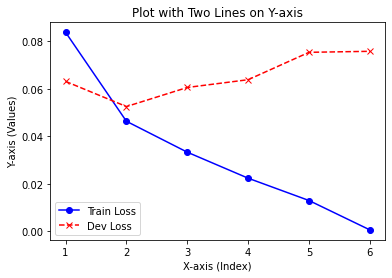

Train (epoch 5): 100%|██████████| 27425/27425 [3:54:05<00:00,  1.95it/s]


In [61]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.
# Copyright (c) 2021, Hitachi America Ltd. All rights reserved.
# This file has been adopted from https://github.com/huggingface/transformers
# /blob/0c9bae09340dd8c6fdf6aa2ea5637e956efe0f7c/examples/question-answering/run.py
# See git log for changes.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import json
import logging
import os

import click
import torch
import transformers
from transformers import AutoConfig, AutoTokenizer
from transformers.trainer_utils import is_main_process

# from contract_nli.conf import load_conf
# from contract_nli.dataset.dataset import load_and_cache_examples, load_and_cache_features
# from contract_nli.dataset.encoder import SPAN_TOKEN
# from contract_nli.evaluation import evaluate_all
# from contract_nli.model.identification_classification import \
#     MODEL_TYPE_TO_CLASS, update_config
# from contract_nli.model.classification import BertForClassification
# from contract_nli.postprocess import format_json
# from contract_nli.predictor import predict, predict_classification
# from contract_nli.trainer import Trainer, setup_optimizer
# from contract_nli.utils import set_seed, distributed_barrier

logger = logging.getLogger(__name__)


# @click.command()
# @click.argument('conf', type=click.Path(exists=True))
# @click.argument('output-dir', type=click.Path(exists=False))
# @click.option(
#     '--local_rank', type=int, default=-1,
#     help='This is automatically set by torch.distributed.launch.')
# @click.option('--shared-filesystem', type=int, default=-1)
# conf, output_dir, local_rank, shared_filesystem
output_dir = './output'
local_rank = -1
shared_filesystem = -1

# Setup CUDA, GPU & distributed training
if local_rank == -1 or conf['no_cuda']:
    device = torch.device("cuda" if torch.cuda.is_available() and not conf['no_cuda'] else "cpu")
    n_gpu = 0 if conf['no_cuda'] else torch.cuda.device_count()
else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    torch.distributed.init_process_group(backend="nccl")
    n_gpu = 1

# if this is a main process in a node
local_main = is_main_process(local_rank)
# if this is a main process in the whole distributed training
all_main = local_rank == -1 or torch.distributed.get_rank() == 0
# if this is a main process on a filesystem
fs_main = (shared_filesystem and all_main) or ((not shared_filesystem) and local_main)

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    filename = "/kaggle/working/output.log",
    level=logging.INFO if local_main else logging.WARN,
)
logger.warning(
    "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
    local_rank,
    device,
    n_gpu,
    bool(local_rank != -1),
    conf['fp16'],
)
# Set the verbosity to info of the Transformers logger (on main process only):
if is_main_process(local_rank):
    transformers.utils.logging.set_verbosity_info()
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()
# Set seed
set_seed(conf['seed'])

with distributed_barrier(not fs_main, local_rank != -1):
    config = AutoConfig.from_pretrained(
        conf['config_name'] if conf['config_name'] else conf['model_name_or_path'],
        cache_dir=conf['cache_dir']
    )
    tokenizer = AutoTokenizer.from_pretrained(
        conf['tokenizer_name'] if conf['tokenizer_name'] else conf['model_name_or_path'],
        do_lower_case=conf['do_lower_case'],
        cache_dir=conf['cache_dir'],
        use_fast=False
    )
    if conf['task'] == 'identification_classification':
        config = update_config(
            config, impossible_strategy='ignore',
            class_loss_weight=conf['class_loss_weight'])
        model = MODEL_TYPE_TO_CLASS[config.model_type].from_pretrained(
            conf['model_name_or_path'],
            from_tf=bool(".ckpt" in conf['model_name_or_path']),
            config=config,
            cache_dir=conf['cache_dir']
        )
    else:
        model = BertForClassification.from_pretrained(
            conf['model_name_or_path'],
            from_tf=bool(".ckpt" in conf['model_name_or_path']),
            config=config,
            cache_dir=conf['cache_dir']
        )

logger.info("Training/evaluation parameters %s",
            {k: v for k, v in conf.items() if k != 'raw_yaml'})

# Before we do anything with models, we want to ensure that we get fp16 execution of torch.einsum if conf['fp16'] is set.
# Otherwise it'll default to "promote" mode, and we'll get fp32 operations. Note that running `--fp16_opt_level="O2"` will
# remove the need for this code, but it is still valid.
if conf['fp16']:
    try:
        import apex
        apex.amp.register_half_function(torch, "einsum")
    except ImportError:
        raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

with distributed_barrier(not fs_main, local_rank != -1):
    examples = load_and_cache_examples(
        conf['train_file'],
        local_rank=local_rank,
        overwrite_cache=conf['overwrite_cache'],
        cache_dir='.',
    )
    if conf['task'] == 'identification_classification':
        n_added_token = tokenizer.add_special_tokens(
            {'additional_special_tokens': tokenizer.additional_special_tokens + [SPAN_TOKEN]})
        if n_added_token == 0:
            logger.warning(
                f'SPAN_TOKEN "{SPAN_TOKEN}" was not added. You can safely ignore'
                ' this warning if you are retraining a model from this train.py')
        else:
            span_token_id = tokenizer.additional_special_tokens_ids[
                tokenizer.additional_special_tokens.index(SPAN_TOKEN)]
            logger.warning(
                f'SPAN_TOKEN "{SPAN_TOKEN}" was added as "{span_token_id}". You can safely ignore'
                ' this warning if you are training a model from pretrained LMs.')
    if conf['symbol_based_hypothesis']:
        hypothesis_symbols = sorted(set([e.hypothesis_symbol for e in examples]))
        n_added_token = tokenizer.add_special_tokens(
            {'additional_special_tokens': tokenizer.additional_special_tokens + hypothesis_symbols})
        if n_added_token == 0:
            logger.warning(
                f'SPAN_TOKEN "{SPAN_TOKEN}" was not added. You can safely ignore'
                ' this warning if you are retraining a model from this train.py')
        else:
            assert n_added_token == len(hypothesis_symbols)
            hypothesis_symbol_dic = {
                s: tokenizer.additional_special_tokens_ids[tokenizer.additional_special_tokens.index(s)]
                for s in hypothesis_symbols
            }
            logger.warning(
                f'Hypothesis symbols were added as "{hypothesis_symbol_dic}". '
                'You can safely ignore this warning if you are training a '
                'model from pretrained LMs.')
    model.resize_token_embeddings(len(tokenizer))

    train_dataset = load_and_cache_features(
        conf['train_file'],
        examples,
        tokenizer,
        max_seq_length=conf['max_seq_length'],
        doc_stride=conf.get('doc_stride', None),
        max_query_length=conf['max_query_length'],
        dataset_type=conf['task'],
        symbol_based_hypothesis=conf['symbol_based_hypothesis'],
        threads=None,
        local_rank=local_rank,
        overwrite_cache=conf['overwrite_cache'],
        labels_available=True,
        cache_dir='.',
    )[0]

if conf['dev_file'] is not None:
    with distributed_barrier(not fs_main, local_rank != -1):
        dev_examples = load_and_cache_examples(
            conf['dev_file'],
            local_rank=local_rank,
            overwrite_cache=conf['overwrite_cache'],
            cache_dir='.'
        )
        dev_dataset, dev_features = load_and_cache_features(
            conf['dev_file'],
            dev_examples,
            tokenizer,
            max_seq_length=conf['max_seq_length'],
            doc_stride=conf.get('doc_stride', None),
            max_query_length=conf['max_query_length'],
            dataset_type=conf['task'],
            symbol_based_hypothesis=conf['symbol_based_hypothesis'],
            threads=None,
            local_rank=local_rank,
            overwrite_cache=conf['overwrite_cache'],
            labels_available=True,
            cache_dir='.'
        )

else:
    dev_dataset, dev_examples, dev_features = None, None, None

optimizer = setup_optimizer(
    model, learning_rate=conf['learning_rate'], epsilon=conf['adam_epsilon'],
    weight_decay=conf['weight_decay'])
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    optimizer=optimizer,
    task=conf['task'],
    output_dir=output_dir,
    per_gpu_train_batch_size=conf['per_gpu_train_batch_size'],
    num_epochs=conf['num_epochs'],
    max_steps=conf['max_steps'],
    dev_dataset=dev_dataset,
    valid_steps=conf['valid_steps'],
    per_gpu_dev_batch_size=conf['per_gpu_eval_batch_size'],
    gradient_accumulation_steps=conf['gradient_accumulation_steps'],
    warmup_steps=conf['warmup_steps'],
    max_grad_norm=conf['max_grad_norm'],
    n_gpu=n_gpu,
    local_rank=local_rank,
    fp16=conf['fp16'],
    fp16_opt_level=conf['fp16_opt_level'],
    device=device,
    save_steps=conf['save_steps'])
trainer.deploy()
trainer.train()

# FIXME: Prediction using multiple GPUs
# if not all_main:
#     return

# Setup CUDA, GPU & distributed training


In [62]:
if local_rank != -1:
    trainer.local_rank = -1

if conf['early_stopping'] and os.path.exists(trainer.best_checkpoint_dir):
    logger.info(f"Loading best model from {trainer.best_checkpoint_dir}")
    trainer.load(trainer.best_checkpoint_dir)
    trainer.deploy()
    model = trainer.model

logger.info("Saving model checkpoint to %s", output_dir)
# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
# Take care of distributed/parallel training
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#     with open(os.path.join(output_dir, "conf.yml"), 'w') as fout:
#         fout.write(conf['raw_yaml'])

if dev_dataset is not None:
    logger.info("Evaluate the on validation data")
    if conf['task'] == 'identification_classification':
        all_results = predict(
            model, dev_dataset, dev_examples, dev_features,
            per_gpu_batch_size=conf['per_gpu_eval_batch_size'],
            device=device, n_gpu=n_gpu,
            weight_class_probs_by_span_probs=conf['weight_class_probs_by_span_probs'])
    else:
        all_results = predict_classification(
            model, dev_dataset, dev_features,
            per_gpu_batch_size=conf['per_gpu_eval_batch_size'],
            device=device, n_gpu=n_gpu)
    result_json = format_json(dev_examples, all_results)
    with open(os.path.join(output_dir, f'result.json'), 'w') as fout:
        json.dump(result_json, fout, indent=2)
    with open(conf['dev_file']) as fin:
        dev_json = json.load(fin)
    
    dev_json['documents'] = dev_json['documents'][: len(dev_json['documents']) // 5]
    
    metrics = evaluate_all(dev_json, result_json,
                           [1, 3, 5, 8, 10, 15, 20, 30, 40, 50],
                           conf['task'])
    logger.info(f"Results@: {json.dumps(metrics, indent=2)}")
    with open(os.path.join(output_dir, f'metrics.json'), 'w') as fout:
        json.dump(metrics, fout, indent=2)

[INFO|configuration_utils.py:657] 2024-11-19 02:22:09,490 >> loading configuration file ./output/best-checkpoint/config.json
[INFO|configuration_utils.py:708] 2024-11-19 02:22:09,492 >> Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForIdentificationClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "class_loss_weight": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "impossible_strategy": "ignore",
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30523
}

[INFO|modeling_utils.py:2105] 2024-11-19 0

In [63]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
import shutil

folder_path = '/kaggle/working/output'  # Replace with your folder path
zip_file_path = '/kaggle/working/output.zip'

shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)


from IPython.display import FileLink

FileLink('/kaggle/working/output.zip')


/kaggle/working/output.zip

In [36]:
# # import os
# os.remove("/kaggle/working/cached_examples_dev")
# os.remove("/kaggle/working/cached_examples_train")
# os.remove("/kaggle/working/cached_features_dev_identification_classification_bert-base-uncased_512_256_64")
# os.remove("/kaggle/working/cached_features_train_identification_classification_bert-base-uncased_512_256_64")